# Adagrad (Adaptive Gradient Algorithm) - Giải Pháp

## Động lực: Tốc độ học Thích ứng (Motivation)

- **Ý tưởng:** Cung cấp một learning rate _riêng biệt cho từng tham số_ và _tự động điều chỉnh_ nó dựa trên "lịch sử" gradient.

## Tiền điều kiện của Adagrad

### Giới thiệu

Trong tối ưu hóa, hình dạng của hàm mất mát quyết định tất cả. Với các bài toán Deep Learning, ta thường mô hình hóa hành vi cục bộ bằng **Hàm bậc hai lồi Convex Quadratic Function:**

$$f(\mathbf{x}) = \frac{1}{2}\mathbf{x}^\top \mathbf{Q}\mathbf{x} + \mathbf{c}^\top \mathbf{x} + b \tag{1}$$

**Trên thực tế của Deep Learning, các bài toán là "Non-convex" (Không lồi), có vô số đỉnh, đáy, đèo, vực thẳm. Việc chứng minh toán học chặt chẽ trên hàm này gần như là bất khả thi.**

Nên nếu một thuật toán (như Adagrad) hoạt động tốt trên hàm lồi bậc hai (giải quyết được vấn đề méo mó, thung lũng hẹp), thì trực giác cho thấy nó cũng sẽ hoạt động tốt trên các bề mặt phức tạp của Deep Learning.

**Lý do Toán học:** Mọi thứ đều là bậc hai khi "Zoom" đủ gần (Khai triển Taylor). Đây là lý do quan trọng nhất về mặt kỹ thuật. Theo định lý Taylor, bất kỳ hàm số trơn nào (dù phức tạp đến đâu), nếu bạn phóng to (zoom) vào cực gần một điểm cực tiểu cục bộ, nó đều trông giống hệt một Hàm bậc hai.

Công thức khai triển Taylor tại điểm $\mathbf{x}$ gần điểm tối ưu $\mathbf{a}$:

$$f(\mathbf{x}) \approx f(\mathbf{a}) + \nabla f(\mathbf{a})^\top (\mathbf{x}-\mathbf{a}) + \frac{1}{2}(\mathbf{x}-\mathbf{a})^\top \mathbf{H} (\mathbf{x}-\mathbf{a})$$

Thành phần thứ 3 ($\frac{1}{2}... \mathbf{H} ...$) chính là dạng Quadratic Function đã đề cập trong phương trình (1) ($\frac{1}{2}\mathbf{x}^\top \mathbf{Q}\mathbf{x}$). Ma trận $\mathbf{Q}$ trong bài học chính là ma trận Hessian ($\mathbf{H}$) tại điểm đó.

**Kết luận:** Để hiểu rõ việc tối ưu tại lân cận cho điểm cực tiểu cho bất kỳ bài toán nào, thì cách tốt nhất chính là thông qua học cách tối ưu cho bài toán hàm bậc hai lồi. Nó là hình ảnh đại diện chính xác cho bài toán khi ta gần chạm tới đích (nhờ Taylor).

### Sự biến đổi của hàm lồi bậc hai

Sau khi đã hiểu được lý do chọn hàm lồi bậc hai để biểu diễn ý nghĩa của việc tối ưu hoá, ta tiếp tục với việc biến đối hàm ban đầu (1) thành hàm:

$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2}\bar{\mathbf{x}}^\top \mathbf{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b \tag{2}$$

Để chứng minh, ta cần 2 giả định toán học quan trọng:

- **Phân rã trị riêng (Eigendecomposition):** $\mathbf{Q} = \mathbf{U}^\top \mathbf{\Lambda} \mathbf{U}$. Với $\mathbf{U}$ là ma trận trực giao (Orthogonal Matrix), có tính chất đặc biệt: $\mathbf{U}^\top = \mathbf{U}^{-1}$ (nghịch đảo bằng chuyển vị) hay $\mathbf{U}^\top \mathbf{U} = \mathbf{I}$. Và $\mathbf{\Lambda}$ là ma trận đường chéo (Diagonal Matrix) chứa các trị riêng.

#### Giải thích chi tiết: Tại sao $\mathbf{Q} = \mathbf{U}\mathbf{\Lambda}\mathbf{U}^\top$?

**1. Lý thuyết đằng sau: ĐỊNH LÝ PHỔ (THE SPECTRAL THEOREM)**

Trong toán học, định lý này phát biểu rằng: _"Mọi ma trận thực đối xứng (Symmetric Real Matrix) đều có thể được chéo hóa bởi một ma trận trực giao."_

**2. Tại sao áp dụng ở đây?**

Ma trận Hessian $\mathbf{Q}$ chứa các đạo hàm riêng bậc hai $\left(\frac{\partial^2 f}{\partial x_i \partial x_j}\right)$. Theo định lý Schwarz trong giải tích, nếu hàm số liên tục thì:

$$\frac{\partial^2 f}{\partial x_i \partial x_j} = \frac{\partial^2 f}{\partial x_j \partial x_i}$$

Điều này nghĩa là $\mathbf{Q}$ luôn đối xứng. Do đó, Định lý Phổ luôn đúng trong trường hợp này.

**3. Quy trình tính toán từng bước (Để tìm $\mathbf{U}$ và $\mathbf{\Lambda}$):**

1. **Bước 1:** Giải phương trình đặc trưng $\det(\mathbf{Q} - \lambda\mathbf{I}) = 0$.  
   _Kết quả:_ Tìm được các nghiệm $\lambda_1, \lambda_2, \dots$ (Đây chính là các phần tử nằm trên đường chéo của ma trận $\mathbf{\Lambda}$).

2. **Bước 2:** Với mỗi $\lambda_i$, giải hệ phương trình $(\mathbf{Q} - \lambda_i\mathbf{I})\mathbf{x} = 0$.  
   _Kết quả:_ Tìm được các vector riêng $\mathbf{v}_i$.

3. **Bước 3 (Quan trọng):** Chuẩn hóa vector riêng (Normalization).  
   Tính $\mathbf{u}_i = \frac{\mathbf{v}_i}{||\mathbf{v}_i||}$ sao cho độ dài vector bằng 1.  
   _Lý thuyết:_ Bước này đảm bảo ma trận $\mathbf{U}$ là trực giao ($\mathbf{U}^\top = \mathbf{U}^{-1}$), giúp việc xoay trục không làm méo kích thước không gian (bảo toàn độ dài Euclid).

#### Đổi biến số (Change of variables)

Ta đặt biến mới: $\bar{\mathbf{x}} = \mathbf{U}\mathbf{x}$.

Từ đó suy ra $\mathbf{x}$ theo $\bar{\mathbf{x}}$: Nhân hai vế với $\mathbf{U}^\top$ (nghịch đảo của $\mathbf{U}$), ta được:

$$\mathbf{x} = \mathbf{U}^\top \bar{\mathbf{x}}$$

Chúng ta sẽ biến đổi từng thành phần của hàm số ban đầu (1).

#### Bước A: Biến đổi Thành phần Bậc hai $\left(\frac{1}{2}\mathbf{x}^\top \mathbf{Q}\mathbf{x}\right)$

Thay thế $\mathbf{Q}$ bằng dạng phân rã $\mathbf{U}^\top \mathbf{\Lambda} \mathbf{U}$:

$$\text{Term}_1 = \frac{1}{2}\mathbf{x}^\top (\mathbf{U}^\top \mathbf{\Lambda} \mathbf{U}) \mathbf{x}$$

Sử dụng tính chất kết hợp của phép nhân ma trận để nhóm lại:

$$\text{Term}_1 = \frac{1}{2}(\mathbf{x}^\top \mathbf{U}^\top) \mathbf{\Lambda} (\mathbf{U} \mathbf{x})$$

Sử dụng tính chất chuyển vị $(\mathbf{A}\mathbf{B})^\top = \mathbf{B}^\top \mathbf{A}^\top$. Ta thấy cụm $(\mathbf{x}^\top \mathbf{U}^\top)$ chính là $(\mathbf{U}\mathbf{x})^\top$. Vậy phương trình trở thành:

$$\text{Term}_1 = \frac{1}{2}(\mathbf{U}\mathbf{x})^\top \mathbf{\Lambda} (\mathbf{U}\mathbf{x})$$

Thay biến mới $\bar{\mathbf{x}} = \mathbf{U}\mathbf{x}$:

$$\text{Term}_1 = \frac{1}{2}\bar{\mathbf{x}}^\top \mathbf{\Lambda} \bar{\mathbf{x}}$$

$\Rightarrow$ Xong phần bậc hai.

#### Bước B: Biến đổi Thành phần Tuyến tính ($\mathbf{c}^\top \mathbf{x}$)

Thay thế $\mathbf{x}$ bằng $\mathbf{U}^\top \bar{\mathbf{x}}$ (như đã rút ra ở mục 2):

$$\text{Term}_2 = \mathbf{c}^\top (\mathbf{U}^\top \bar{\mathbf{x}})$$

Nhóm các vector hệ số lại:

$$\text{Term}_2 = (\mathbf{c}^\top \mathbf{U}^\top) \bar{\mathbf{x}}$$

Sử dụng tính chất chuyển vị ngược lại $\mathbf{B}^\top \mathbf{A}^\top = (\mathbf{A}\mathbf{B})^\top$. Cụm $(\mathbf{c}^\top \mathbf{U}^\top)$ chính là $(\mathbf{U}\mathbf{c})^\top$:

$$\text{Term}_2 = (\mathbf{U}\mathbf{c})^\top \bar{\mathbf{x}}$$

Tài liệu định nghĩa vector hệ số mới $\bar{\mathbf{c}} = \mathbf{U}\mathbf{c}$. Vậy ta có:

$$\text{Term}_2 = \bar{\mathbf{c}}^\top \bar{\mathbf{x}}$$

$\Rightarrow$ Xong phần tuyến tính.

#### Bước C: Tổng hợp kết quả

Ghép Bước A và Bước B lại với hằng số $b$ (hằng số $b$ giữ nguyên vì không chứa $\mathbf{x}$), ta có công thức cuối cùng:

$$f(\mathbf{x}) \rightarrow \bar{f}(\bar{\mathbf{x}}) = \underbrace{\frac{1}{2}\bar{\mathbf{x}}^\top \mathbf{\Lambda} \bar{\mathbf{x}}}_{\text{Từ bước A}} + \underbrace{\bar{\mathbf{c}}^\top \bar{\mathbf{x}}}_{\text{Từ bước B}} + b$$

Đây chính xác là công thức 12.7.1 của D2L hay là hàm số (2)

**Vấn đề:** Nếu ma trận Hessian $\mathbf{Q}$ có Số điều kiện (Condition Number) lớn ($\lambda_{max} \gg \lambda_{min}$), hàm số sẽ có dạng thung lũng hẹp

**Hậu quả:** Gradient Descent thông thường sẽ bị dao động mạnh (zigzag) tại vách núi dựng đứng và di chuyển rùa bò tại lòng thung lũng phẳng.

### Tiền điều kiện (Preconditioning)

Vì việc tính toàn bộ trị riêng quá tốn kém ($O(d^3)$), ta dùng phương pháp xấp xỉ: Chuẩn hóa dựa trên đường chéo. Công thức tổng quát:

$$\tilde{\mathbf{Q}} = \text{diag}^{-\frac{1}{2}}(\mathbf{Q})\mathbf{Q}\text{diag}^{-\frac{1}{2}}(\mathbf{Q}) \tag{3}$$

Việc tính các giá trị của ma trận sẽ được tính theo công thức:

$$\tilde{\mathbf{Q}}_{ij} = \frac{\mathbf{Q}_{ij}}{\sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}}$$

#### Quy trình tính toán từng bước (Step-by-step Derivation)

Giả sử ta có ma trận Hessian rất "méo": $\mathbf{Q} = \begin{bmatrix} 100 & 5 \\ 5 & 1 \end{bmatrix}$.

**Bước 1: Tạo ma trận tỉ lệ $\mathbf{S}$**

Lấy nghịch đảo căn bậc hai đường chéo:

$$\mathbf{S} = \text{diag}(\frac{1}{\sqrt{100}}, \frac{1}{\sqrt{1}}) = \begin{bmatrix} 0.1 & 0 \\ 0 & 1 \end{bmatrix}$$

**Bước 2: Biến đổi ma trận $\tilde{\mathbf{Q}} = \mathbf{S}\mathbf{Q}\mathbf{S}$**

- $\tilde{Q}_{11} = 100 \times 0.1 \times 0.1 = \mathbf{1}$.
- $\tilde{Q}_{22} = 1 \times 1 \times 1 = \mathbf{1}$.
- $\tilde{Q}_{12} = 5 \times 0.1 \times 1 = \mathbf{0.5}$.

$\Rightarrow$ Kết quả: $\tilde{\mathbf{Q}} = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix}$.

**Ý nghĩa:** Đường chéo đã được chuẩn hóa về 1. Không gian đã được cân bằng lại, giúp thuật toán di chuyển dễ dàng hơn.

### Từ Lý thuyết đến Thực hành

Trong thực tế, ta thậm chí không biết ma trận $\mathbf{Q}$ (Hessian). Làm sao ta áp dụng phép tiền điều kiện trên?

Chúng ta dựa vào Khai triển Taylor bậc 2 quanh điểm cực tiểu $\mathbf{x}^*$:

$$f(\mathbf{x}) \approx f(\mathbf{x}^*) + \frac{1}{2}(\mathbf{x}-\mathbf{x}^*)^\top \mathbf{H} (\mathbf{x}-\mathbf{x}^*)$$

Lấy đạo hàm (Gradient) hai vế:

$$\mathbf{g} = \nabla f(\mathbf{x}) \approx \mathbf{H} (\mathbf{x}-\mathbf{x}^*)$$

#### Suy luận Heuristic (Quy tắc ngón tay cái)

Từ phương trình trên, nếu ta coi khoảng cách tới đích $(\mathbf{x}-\mathbf{x}^*)$ là đại lượng biến thiên chậm, ta có mối tương quan tỉ lệ thuận:

$$||\mathbf{g}|| \propto ||\mathbf{H}||$$

- Gradient lớn $\Rightarrow$ Hessian lớn (Độ cong lớn/Dốc đứng).
- Gradient nhỏ $\Rightarrow$ Hessian nhỏ (Độ cong nhỏ/Phẳng).

$\Rightarrow$ **Chiến lược:** Sử dụng Tổng bình phương Gradient ($\sum \mathbf{g}^2$) làm biến đại diện (Proxy) cho Hessian ($\mathbf{Q}$) để thực hiện phép chia tỉ lệ.

## Thuật toán Adagrad

- **Biến trạng thái (State Variable):** $s_t$, một véc-tơ tích lũy _tổng bình phương_ của các gradient trong quá khứ.

- **Công thức tích lũy:** (với $g_t$ là gradient tại bước $t$)

$$s_t = s_{t-1} + g_t^2$$

- **Công thức cập nhật (Update Rule):**

$$W_{t+1} = W_t - \frac{\eta}{\sqrt{s_t + \epsilon}} \odot g_t$$

  - $\eta$ là learning rate **toàn cục**.
  - $\epsilon$ là hằng số nhỏ (ví dụ $1e-7$) để tránh chia cho 0.
  - $\odot$ là phép nhân element-wise.
  - Phân số $\frac{\eta}{\sqrt{s_t + \epsilon}}$ là **learning rate thích ứng** cho từng tham số.

### Giải thích thêm cho việc tại sao learning rate được chia cho căn bậc 2 tổng tích luỹ bình phương

1. **Lý do Toán học: Mô phỏng công thức (3)**
   - Lý thuyết bảo rằng: Muốn chuẩn hóa hình dạng hàm số (biến elip thành hình tròn), ta phải chia tỉ lệ trục tọa độ cho căn bậc hai của độ cong Hessian ($\sqrt{\mathbf{Q}_{ii}}$).
   - Adagrad: Vì không có Hessian, ta dùng tổng bình phương Gradient ($\mathbf{s}_t$) để thay thế.
   - Kết luận: Dấu căn bậc hai $\sqrt{\mathbf{s}_t}$ xuất hiện chính là để thực hiện đúng phép toán "mũ $-1/2$" của lý thuyết

2. **Lý do Thống kê: Chuẩn hóa về độ lệch chuẩn (RMS)**

   Trong thống kê, $\mathbf{s}_t = \sum \mathbf{g}^2$ đại diện cho tổng phương sai (variance) chưa chuẩn hóa. Nếu Gradient biến động mạnh (lớn), phương sai ($\mathbf{s}_t$) sẽ rất lớn.

   Để đo "quy mô" (scale) của sự biến động, ta không dùng phương sai, mà dùng Độ lệch chuẩn (Standard Deviation). Công thức độ lệch chuẩn là: $\sigma = \sqrt{\text{Variance}}$.

   Bằng cách chia cho $\sqrt{\mathbf{s}_t}$, Adagrad thực chất đang làm một phép tính gọi là RMS Normalization (Root Mean Square). Nó đưa các gradient có độ lớn khác nhau về cùng một quy mô đơn vị.

   - Gradient lớn $\rightarrow$ Chia cho số lớn.
   - Gradient nhỏ $\rightarrow$ Chia cho số nhỏ.

   Kết quả là các bước cập nhật trở nên đồng đều hơn.

3. **Cơ chế "Phanh"**

   Hãy tưởng tượng $\sqrt{\mathbf{s}_t}$ như một bộ phận cảm biến tốc độ. Tại sao cần Căn bậc 2 mà không để nguyên $\mathbf{s}_t$?

   $\mathbf{s}_t$ là tổng của các bình phương ($g^2$). Nó tăng lên rất nhanh và có giá trị cực lớn. Nếu chia cho $\mathbf{s}_t$ (không có căn), mẫu số sẽ quá lớn, làm cho Learning Rate tụt về 0 quá nhanh $\rightarrow$ Mô hình ngừng học ngay lập tức (Early Stopping).

   Dùng Căn bậc 2 giúp kìm hãm sự tăng trưởng của mẫu số, giữ cho nó tuyến tính với độ lớn của gradient, giúp Learning Rate giảm từ từ một cách hợp lý ($O(t^{-1/2})$) thay vì tụt dốc không phanh ($O(t^{-1})$).

## Ví dụ Tính toán Cụ thể cho Adagrad

### Tổng quan: Cơ chế Adagrad và Lý thuyết Khởi tạo Trọng số

Trong phần này, chúng ta sẽ đi sâu vào cách thuật toán Adagrad hoạt động thông qua một ví dụ tính toán thủ công, sau đó giải thích tại sao các con số khởi tạo trong ví dụ lại khác với thực tế triển khai trong các thư viện Deep Learning.

### Phần 1: Ví dụ Tính toán "Coordinate-wise" (Từng tọa độ)

Adagrad nổi bật nhờ khả năng điều chỉnh tốc độ học (learning rate) riêng biệt cho từng tham số dựa trên tần suất xuất hiện của chúng. Để minh họa, ta xét bài toán tối ưu hóa với 2 tham số đại diện cho 2 trường hợp đối lập.

#### 1. Thiết lập Bài toán (Setup)

**Mô hình:** 2 trọng số $\mathbf{w} = [w_1, w_2]$.

- $w_1$: Đặc trưng phổ biến, xuất hiện nhiều (VD: từ "learning").
- $w_2$: Đặc trưng hiếm, ít xuất hiện (VD: từ "preconditioning").

**Khởi tạo:**

- Trọng số: $\mathbf{w}_0 = [1.0, 1.0]$.
- Biến tích lũy gradient: $\mathbf{s}_0 = [0, 0]$.
- Siêu tham số: Learning Rate $\eta = 0.1$, $\epsilon \approx 0$.

#### 2. Bước 1: Sự cân bằng tự động ($t=1$)

Giả sử tại bước đầu tiên, Gradient trả về cho thấy $w_1$ có độ dốc lớn gấp 40 lần $w_2$.

**Input Gradient:** $\mathbf{g}_1 = [4.0, \quad 0.1]$.

**Quá trình tính toán:**

1. **Bình phương Gradient ($g^2$):** Tính riêng cho từng tọa độ.

   $$[4.0^2, \quad 0.1^2] = [16.0, \quad 0.01]$$

2. **Tích lũy vào $\mathbf{s}$ ($s_t = s_{t-1} + g^2$):**

   $$\mathbf{s}_1 = [0, 0] + [16.0, 0.01] = [16.0, \quad 0.01]$$

3. **Hệ số điều chỉnh ($\frac{1}{\sqrt{s}}$):** Đây là bước "phanh" hoặc "tăng tốc".

   - Với $w_1$: $1 / \sqrt{16.0} = 0.25$ (Hệ số nhỏ $\rightarrow$ Phanh gấp).
   - Với $w_2$: $1 / \sqrt{0.01} = 10.0$ (Hệ số lớn $\rightarrow$ Tăng tốc).

4. **Cập nhật trọng số:**

   $$\Delta w_1 = 0.1 \times 0.25 \times 4.0 = \mathbf{0.1}$$
   $$\Delta w_2 = 0.1 \times 10.0 \times 0.1 = \mathbf{0.1}$$
   $$\mathbf{w}_1 = [1.0 - 0.1, \quad 1.0 - 0.1] = [0.9, \quad 0.9]$$

**Nhận xét:** Dù gradient chênh lệch 40 lần, Adagrad đã tự động cân bằng để cả hai tham số di chuyển cùng một quãng đường.

#### 3. Bước 2: Hiệu ứng tích lũy ($t=2$)

Giả sử Gradient tiếp tục duy trì xu hướng cũ: $\mathbf{g}_2 = [2.0, \quad 0.1]$.

**Quá trình tính toán:**

1. **Tích lũy tiếp vào $\mathbf{s}$:**

   $$\mathbf{s}_2 = \mathbf{s}_1 + g_2^2 = [16.0, 0.01] + [4.0, 0.01] = [20.0, \quad 0.02]$$

2. **Learning Rate hiệu dụng (Individual Learning Rate):**

   - Với $w_1$ (Dốc/Nhiều): $\eta_{eff} \approx 0.1 / \sqrt{20} \approx \mathbf{0.022}$ (Giảm dần).
   - Với $w_2$ (Thoải/Hiếm): $\eta_{eff} \approx 0.1 / \sqrt{0.02} \approx \mathbf{0.707}$ (Vẫn rất cao).

3. **Bước nhảy thực tế:**

   - $w_1$ di chuyển một đoạn rất nhỏ: $0.044$.
   - $w_2$ di chuyển một đoạn lớn hơn gradient của nó: $0.07$.

**Kết luận:** Mỗi tham số sở hữu một tốc độ học riêng biệt. Tham số "learning" ($w_1$) học chậm lại để hội tụ, tham số "preconditioning" ($w_2$) giữ tốc độ cao để bắt kịp.

### Phần 2: Lý thuyết Khởi tạo Trọng số (Weight Initialization)

Trong ví dụ trên, ta đã chọn $\mathbf{w}_0 = [1.0, 1.0]$. Tuy nhiên, trong thực tế, việc chọn con số này tuân theo các nguyên tắc nghiêm ngặt hơn nhiều.

#### 1. Tại sao trong ví dụ lại chọn $\mathbf{w}_0 = [1.0, 1.0]$?

Việc chọn giá trị này hoàn toàn phục vụ mục đích Sư phạm (Pedagogical):

- **Tối giản tính toán:** Giúp ta tập trung vào cơ chế của thuật toán thay vì bị rối bởi các con số thập phân phức tạp (như $0.14159...$).
- **Cô lập biến số:** Bằng cách để xuất phát điểm ngang bằng nhau, ta chứng minh được rằng sự thay đổi tốc độ học ở Bước 1 và 2 hoàn toàn do Gradient và Adagrad tạo ra, chứ không phải do trọng số ban đầu khác nhau.

#### 2. Tại sao KHÔNG làm thế trong thực tế? (Cạm bẫy Đối xứng)

Nếu áp dụng $\mathbf{w}_0 = [1.0, 1.0]$ cho code thực tế, bạn sẽ gặp Vấn đề Đối xứng (Symmetry Problem):

- Tất cả nơ-ron thực hiện phép tính y hệt nhau.
- Tất cả Gradient trả về giống hệt nhau.
- Cả mạng nơ-ron khổng lồ sẽ hoạt động như một nơ-ron duy nhất, không thể học được các đặc trưng phức tạp.

#### 3. Giải pháp Thực tế: Bảo toàn Phương sai (Variance Preservation)

Trong Deep Learning thực tế (PyTorch/TensorFlow), trọng số được khởi tạo ngẫu nhiên dựa trên nguyên lý: "Phương sai đầu ra phải bằng phương sai đầu vào" để tránh Vanishing/Exploding Gradient.

- **He Initialization (cho ReLU):** Khởi tạo ngẫu nhiên từ phân phối chuẩn với phương sai $\text{Var}(W) = \frac{2}{n_{in}}$. Đây là chuẩn mực hiện đại cho các mạng ConvNet/ResNet.
- **Xavier/Glorot Initialization (cho Sigmoid/Tanh):** Khởi tạo với phương sai $\text{Var}(W) = \frac{1}{n_{in}}$.

#### Tóm lại

Ví dụ tính toán $\mathbf{w}_0=[1.0, 1.0]$ là một mô hình "trong phòng thí nghiệm" để hiểu cơ chế cân bằng bước nhảy của Adagrad. Còn trong "thế giới thực", ta phải dùng He/Xavier Initialization để phá vỡ tính đối xứng và đảm bảo tín hiệu truyền đi ổn định.

**Kết luận ví dụ:** Learning rate của $w_1$ (phổ biến) liên tục giảm, trong khi learning rate của $w_2$ (hiếm) chỉ giảm khi nó thực sự xuất hiện.

## Phân tích Ưu điểm và Nhược điểm

- **Ưu điểm:**
  - Giải quyết hoàn hảo bài toán **gradient thưa** (sparse gradient).
  - Tự động điều chỉnh learning rate.

- **Nhược điểm (Vấn đề chí mạng):**
  - Biến tích lũy $s_t$ luôn _tăng_ và không bao giờ giảm (vì $g_t^2 \ge 0$).
  - Dẫn đến learning rate **giảm dần về 0** $\implies$ Thuật toán **dừng học (stop learning)** quá sớm.

In [3]:
# 1. Restart kernel (Kernel → Restart)
# 2. Run this in first cell:
import torch
import gc

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
%reset -f  # Clear all variables


Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clear, please run `%reset?` for details
Don't know how to reset  all, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details


In [4]:
# ============================================================================
# COMPLETE CACHE CLEANUP FOR JUPYTER + PYTORCH
# ============================================================================

import gc
import torch
from IPython import get_ipython

def cleanup_memory():
    """Complete cleanup of memory and cache"""
    
    # 1. Delete all user variables (keep imports)
    print("Cleaning up variables...")
    ipython = get_ipython()
    if ipython:
        # Get all variable names
        user_ns = ipython.user_ns
        to_delete = [var for var in user_ns if not var.startswith('_')]
        
        for var in to_delete:
            if var not in ['In', 'Out', 'get_ipython', 'exit', 'quit']:
                del user_ns[var]
    
    # 2. Clear CUDA cache
    if torch.cuda.is_available():
        print("Clearing CUDA cache...")
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    
    # 3. Run garbage collector
    print("Running garbage collector...")
    gc.collect()
    
    # 4. Print memory status
    if torch.cuda.is_available():
        print(f"\nGPU Memory:")
        print(f"  Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"  Reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")
    
    print("\n✓ Cleanup complete!")

# Run cleanup
cleanup_memory()


Cleaning up variables...


NameError: name 'torch' is not defined

## Adagrad trên Python

### Minh hoạ tối ưu hoá Adagrad trên hàm số

https://colab.research.google.com/drive/1InbIefqC95uq7SNLxdy86s0FvWBUjNpm?usp=sharing

Hàm số dùng để tối ưu hoá là:

$$f(\mathbf{x}) = 0.1x_1^2 + 2x_2^2$$

Với learning rate $\eta = 0.4$

epoch 20, x1: -2.382563, x2: -0.158591


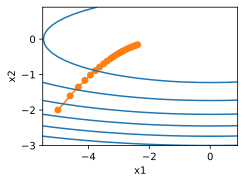

In [1]:
import math
import torch
from d2l import torch as d2l

def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

**Hình ảnh**: Minh hoạ đường đi của adagrad  
_(Note: Original SVG reference: `Images/adagrad/adagrad_2d`)_

Để hiểu hình này, chúng ta cần phân tích 3 thành phần chính: Địa hình (các đường xanh), Hành trình (đường cam) và Tốc độ (khoảng cách giữa các điểm).

1. **Địa hình: Các đường đồng mức màu xanh**
   - Hình dáng: Đây là một cái bát hình elip bị kéo dãn.
   - Trục dọc ($x_2$): Có hệ số là 2 (lớn). Điều này nghĩa là hướng này rất dốc. Chỉ cần nhích nhẹ $x_2$, giá trị hàm số thay đổi rất mạnh. Các đường xanh nằm sát nhau biểu thị độ dốc lớn này.
   - Trục ngang ($x_1$): Có hệ số là 0.1 (nhỏ). Điều này nghĩa là hướng này rất thoải (phẳng). Các đường xanh nằm cách xa nhau.

2. **Hành trình: Đường màu cam (Quỹ đạo Adagrad)**

   Các chấm màu cam là vị trí của $(\mathbf{x}_1, \mathbf{x}_2)$ sau mỗi bước cập nhật (epoch). Đường nối chúng là đường đi của thuật toán.

   - Nếu dùng thuật toán thường (như SGD), vì trục dọc ($x_2$) quá dốc, thuật toán sẽ bị văng qua lại mạnh (zigzag) theo chiều dọc và đi rất chậm theo chiều ngang.
   - Adagrad thấy Gradient ở trục dọc ($x_2$) rất lớn $\rightarrow$ Nó tích lũy vào $\mathbf{s}_2$ $\rightarrow$ và chia learning rate cho số lớn này. Sau đó bước đi theo chiều dọc tự động nhỏ lại (Hãm phanh).
   - Adagrad thấy ở trục ngang ($x_1$) rất nhỏ $\rightarrow$ nên tích lũy vào $\mathbf{s}_1$ (số nhỏ) $\rightarrow$ và chia learning rate cho số nhỏ $\rightarrow$. Bước đi theo chiều ngang được giữ nguyên hoặc lớn hơn (Tăng tốc).
   - Kết quả: Ta thấy đường màu cam không bị zigzag hỗn loạn mà uốn cong một cách mượt mà về phía tâm. Nó đi cẩn thận ở chỗ nguy hiểm ($x_2$) và đi dứt khoát ở chỗ an toàn ($x_1$).

3. **Tốc độ: Khoảng cách giữa các chấm cam**

   Hãy nhìn kỹ các chấm cam:

   - Lúc đầu: Các chấm cách xa nhau (bước nhảy lớn).
   - Càng về sau: Các chấm xít lại gần nhau dày đặc (bước nhảy li ti).

   Lý do: Đây là minh chứng cho việc Learning Rate giảm dần (Decay).

   - Công thức cập nhật có mẫu số là $\sqrt{\mathbf{s}_t}$.
   - Vì $\mathbf{s}_t$ cứ cộng dồn mãi ($\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}^2$), nên mẫu số càng ngày càng to.
   - Kết quả là càng về cuối, Adagrad càng "đuối sức", bước đi trở nên rất nhỏ, khiến nó mất nhiều thời gian để nhích từng chút một vào tâm điểm $(0,0)$.

### Xây dựng thuật toán Adagrad từ công thức

Chúng ta sẽ viết code Python từ đầu cho thuật toán Adagrad dựa trên những gì đã nhắc tới và huấn luyện mô hình

loss: 0.243, 0.038 sec/epoch


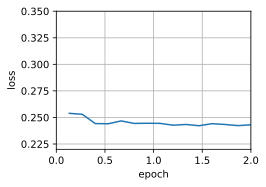

In [5]:
import math
import torch
from d2l import torch as d2l
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                            '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    """Defined in :numref:`sec_minibatches`"""
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    """Defined in :numref:`sec_minibatches`"""
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                    requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss

    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                           (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()
        
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

### Minh hoạ Adagrad trên tệp RCV1

Device đang chạy: cuda
Downloading/Loading RCV1...
Dataset Loaded. Samples: 23149, Features: 47236
--------------------------------------------------
Đang chạy Adagrad với LR=0.1...
Bắt đầu Training Pure ADAGRAD (Total samples: 23149)...
Epoch 1 | Sample 0/23149 | Loss: 0.6851
Epoch 1 | Sample 5000/23149 | Loss: 0.0247
Epoch 1 | Sample 10000/23149 | Loss: 0.0738
Epoch 1 | Sample 15000/23149 | Loss: 0.3000
Epoch 1 | Sample 20000/23149 | Loss: 0.1692
--> Kết thúc Epoch 1
Epoch 2 | Sample 0/23149 | Loss: 0.1036
Epoch 2 | Sample 5000/23149 | Loss: 0.1669
Epoch 2 | Sample 10000/23149 | Loss: 0.5818
Epoch 2 | Sample 15000/23149 | Loss: 0.0044
Epoch 2 | Sample 20000/23149 | Loss: 0.1906
--> Kết thúc Epoch 2
Epoch 3 | Sample 0/23149 | Loss: 0.0163
Epoch 3 | Sample 5000/23149 | Loss: 0.0138
Epoch 3 | Sample 10000/23149 | Loss: 0.2857
Epoch 3 | Sample 15000/23149 | Loss: 0.9627
Epoch 3 | Sample 20000/23149 | Loss: 0.0410
--> Kết thúc Epoch 3
Epoch 4 | Sample 0/23149 | Loss: 0.5175
Epoch 4 | Samp

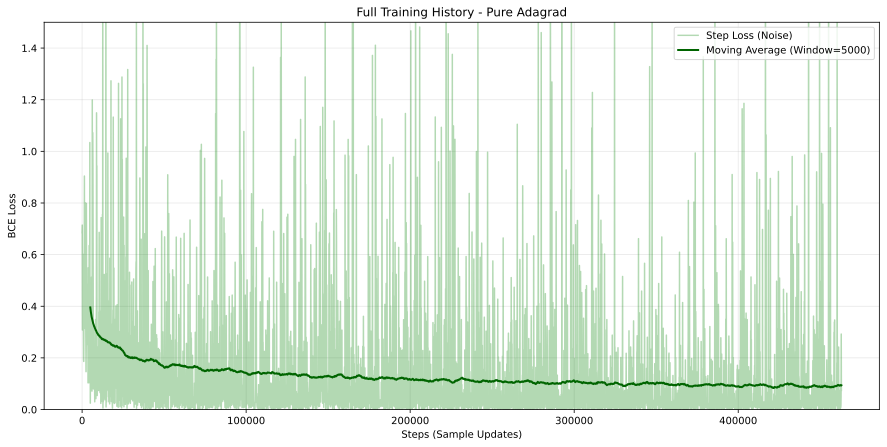

In [ ]:
# import torch
# import torch.nn as nn
# import time
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.datasets import fetch_rcv1

# # 1. Setup & Load Data
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Device đang chạy: {device}")

# print("Downloading/Loading RCV1...")
# rcv1 = fetch_rcv1(subset='train')
# n_samples, n_features = rcv1.data.shape

# # Xử lý nhãn (Label Processing)
# topic_counts = rcv1.target.sum(axis=0)
# most_frequent_topic_idx = np.argmax(topic_counts)
# y_full = rcv1.target[:, most_frequent_topic_idx].toarray().ravel()
# y_cpu = torch.tensor(y_full, dtype=torch.float32).view(-1, 1)

# print(f"Dataset Loaded. Samples: {n_samples}, Features: {n_features}")
# print("-" * 50)

# # 2. Hàm Train ADAGRAD
# def train_adagrad_visualize(X_scipy, y_cpu, lr=0.01, epochs=1, epsilon=1e-8):
#     # Khởi tạo tham số W và b
#     W = torch.normal(0, 0.01, size=(n_features, 1), requires_grad=True, device=device)
#     b = torch.zeros(1, requires_grad=True, device=device)

#     # --- KHỞI TẠO BỘ NHỚ ADAGRAD (Accumulated Squared Gradients) ---
#     G_W = torch.zeros_like(W, device=device)
#     G_b = torch.zeros_like(b, device=device)

#     criterion = nn.BCEWithLogitsLoss()
#     step_losses = []

#     print(f"Bắt đầu Training Pure ADAGRAD (Total samples: {n_samples})...")
#     start_time = time.time()

#     for epoch in range(epochs):
#         indices = np.random.permutation(n_samples)
#         for i, idx in enumerate(indices):
#             # Lấy 1 mẫu (Stochastic)
#             X_sample = torch.tensor(X_scipy[idx].toarray(), dtype=torch.float32).to(device)
#             y_sample = y_cpu[idx].to(device).view(1, 1)

#             # Forward
#             linear_out = X_sample @ W + b
#             loss = criterion(linear_out, y_sample)

#             # Backward
#             loss.backward()

#             # --- CẬP NHẬT TRỌNG SỐ THEO CÔNG THỨC ADAGRAD ---
#             with torch.no_grad():
#                 # 1. Cộng dồn bình phương gradient vào bộ nhớ (G_t = G_{t-1} + g_t^2)
#                 G_W += W.grad ** 2
#                 G_b += b.grad ** 2

#                 # 2. Tính mẫu số điều chỉnh (căn bậc hai của G + epsilon)
#                 std_W = torch.sqrt(G_W) + epsilon
#                 std_b = torch.sqrt(G_b) + epsilon

#                 # 3. Update tham số: W = W - (lr / std) * grad
#                 W -= (lr / std_W) * W.grad
#                 b -= (lr / std_b) * b.grad

#                 # 4. Reset gradient
#                 W.grad.zero_()
#                 b.grad.zero_()

#             # Lưu lại loss
#             current_loss = loss.item()
#             step_losses.append(current_loss)

#             # In tiến độ
#             if i % 5000 == 0:
#                 print(f"Epoch {epoch+1} | Sample {i}/{n_samples} | Loss: {current_loss:.4f}")

#         print(f"--> Kết thúc Epoch {epoch+1}")

#     print(f"Tổng thời gian: {time.time() - start_time:.2f}s")
#     return step_losses

# # 3. Hàm Visualize
# def plot_full_training_history(losses, alg_name="Adagrad", window_size=1000, downsample_rate=100):
#     plt.figure(figsize=(15, 7))
#     total_steps = len(losses)

#     # Vẽ Loss thực tế (Downsampling)
#     steps = range(0, total_steps, downsample_rate)
#     sampled_losses = [losses[i] for i in steps]
#     plt.plot(steps, sampled_losses, color='green', alpha=0.3, label='Step Loss (Noise)')

#     # Vẽ Moving Average
#     if total_steps > window_size:
#         moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
#         ma_x_axis = range(window_size-1, total_steps)
#         plt.plot(ma_x_axis[::downsample_rate], moving_avg[::downsample_rate],
#                 color='darkgreen', linewidth=2, label=f'Moving Average (Window={window_size})')

#     plt.title(f'Full Training History - {alg_name}')
#     plt.xlabel('Steps (Sample Updates)')
#     plt.ylabel('BCE Loss')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.ylim(0, 1.5)
#     plt.show()

# # --- SỬ DỤNG ---
# LR = 0.1  # Adagrad thích LR khởi đầu lớn hơn SGD
# EPOCHS = 20

# print(f"Đang chạy Adagrad với LR={LR}...")
# loss_history_adagrad = train_adagrad_visualize(rcv1.data, y_cpu, lr=LR, epochs=EPOCHS)
# plot_full_training_history(loss_history_adagrad, alg_name="Pure Adagrad", 
#                            window_size=5000, downsample_rate=100)

## So sánh giữa Adagrad và SGD trên tệp RCV1

### Thiết lập Thực nghiệm

- **Tập dữ liệu:** RCV1 (Reuters Corpus Volume I).
- **Số lượng mẫu:** 23,149.
- **Số lượng đặc trưng:** 47,236 (Dữ liệu cao chiều và thưa).
- **Môi trường:** CUDA (GPU RTX3080).
- **Tham số:** Cả hai thuật toán được khởi chạy với cùng thiết lập learning rate ban đầu để đảm bảo tính công bằng trong so sánh.

### Kết quả Thực nghiệm

Dựa trên log huấn luyện qua 20 epochs, chúng tôi tổng hợp các chỉ số quan trọng tại các mốc thời gian đại diện trong bảng dưới đây.

### So sánh Loss và Độ ổn định giữa Adagrad và SGD qua các Epoch

| Metric | Epoch | Adagrad Loss | SGD Loss | Nhận xét |
|---|---|---|---|---|
| Khởi tạo | 1 | 0.6934 | 0.6814 | Tương đương |
| Hội tụ sớm | 3 | **0.0023** | 0.5129 | Adagrad hội tụ cực nhanh |
| Giữa kỳ | 12 | 0.1339 | **1.0979** | SGD bị văng (Spike) |
| Ổn định | 16 | 0.2659 | 0.1450 | Cả hai đều dao động |
| Kết thúc | 20 | **0.0017** | 0.2846 | Adagrad đạt tối ưu sâu hơn |
| **Thời gian** | Total | 538.94s | **496.02s** | SGD nhanh hơn $\approx$ 43s |

### So sánh giữa hai thuật toán tối ưu

#### Khả năng xử lý dữ liệu thưa (Sparsity Handling)

Tập dữ liệu RCV1 có đặc tính là các đặc trưng (từ vựng) xuất hiện với tần suất rất khác nhau.

- **SGD:** Sử dụng learning rate cố định cho toàn bộ 47,236 đặc trưng. Điều này dẫn đến việc các đặc trưng hiếm (rare features) không được cập nhật đủ lớn, trong khi các đặc trưng phổ biến lại bị cập nhật quá đà. Minh chứng rõ nhất là tại **Epoch 12**, SGD có loss vọt lên $1.0979$, cho thấy hiện tượng "overshooting" (văng khỏi đáy).

- **Adagrad:** Cơ chế $\frac{\eta}{\sqrt{\mathbf{s}_t}}$ cho phép thuật toán tự động gán learning rate lớn cho các tham số có gradient thưa thớt. Kết quả là ngay tại **Epoch 3**, Loss của Adagrad đã giảm sâu xuống $0.0023$, chứng tỏ khả năng "bắt" các đặc trưng quan trọng cực kỳ hiệu quả.

#### Độ ổn định hội tụ (Convergence Stability)

Quan sát hành vi loss ở 5 epoch cuối (16-20):

- **SGD:** Vẫn thể hiện sự bất ổn định cao với các giá trị loss dao động biên độ lớn (từ $0.06$ đến $0.93$ tại Epoch 18). Điều này cho thấy thuật toán vẫn đang dao động quanh vùng tối ưu mà không thể hội tụ chặt chẽ.

- **Adagrad:** Duy trì mức loss thấp và ổn định hơn. Mặc dù vẫn có dao động (do tính chất Stochastic), nhưng biên độ nhỏ hơn đáng kể. Điều này phù hợp với lý thuyết: learning rate của Adagrad giảm dần theo thời gian ($O(t^{-1/2})$), đóng vai trò như cơ chế "hãm phanh" (annealing) giúp thuật toán tinh chỉnh (fine-tune) chính xác vào điểm cực tiểu.

#### Chi phí tính toán (Computational Cost)

Về mặt thời gian thực thi:

$$T_{Adagrad} (538.94s) > T_{SGD} (496.02s)$$

Sự chênh lệch này là khoảng 8.6%. Nguyên nhân đến từ việc Adagrad phải duy trì và cập nhật thêm ma trận tích lũy gradient $\mathbf{s}_t$ và thực hiện phép tính căn bậc hai tại mỗi bước lặp. Tuy nhiên, xét trên hiệu quả hội tụ (đạt loss thấp nhanh gấp 4-5 lần), sự đánh đổi này là hoàn toàn xứng đáng.

## Bài tập -- Chương 11.7 Adagrad (D2L)

### Ghi chú

Ký hiệu: $\|\cdot\|_2$ là chuẩn Euclid; $\mathbf{I}$ là ma trận đơn vị; $\mathbf{Q}^\top$ là chuyển vị của $\mathbf{Q}$.

### Bài 1

**Đề bài.** Cho ma trận trực giao $\mathbf{U}$ và vector $\mathbf{c},\boldsymbol\delta$. Chứng minh

$$\|\mathbf{c}-\boldsymbol\delta\|_2 \;=\; \|\mathbf{U}\mathbf{c}-\mathbf{U}\boldsymbol\delta\|_2.$$

Tại sao điều này có nghĩa là độ lớn của nhiễu loạn không thay đổi sau khi thay đổi trực giao của các biến?

**Lời giải.** Đặt $\mathbf{v}=\mathbf{c}-\boldsymbol\delta$. Khi đó cần chứng minh

$$\|\mathbf{v}\|_2 = \|\mathbf{U}\mathbf{v}\|_2.$$

Ta có

$$\|\mathbf{U}\mathbf{v}\|_2^2 = (\mathbf{U}\mathbf{v})^\top(\mathbf{U}\mathbf{v})
= \mathbf{v}^\top \mathbf{U}^\top \mathbf{U} \mathbf{v}.$$

Vì $\mathbf{U}$ là ma trận trực giao nên $\mathbf{U}^\top\mathbf{U}=\mathbf{I}$. Do đó

$$\|\mathbf{U}\mathbf{v}\|_2^2 = \mathbf{v}^\top\mathbf{I}\mathbf{v} = \mathbf{v}^\top\mathbf{v} = \|\mathbf{v}\|_2^2.$$

Lấy căn bậc hai hai vế (cả hai không âm) thu được kết quả mong muốn:

$$\|\mathbf{U}\mathbf{v}\|_2 = \|\mathbf{v}\|_2.$$

_Giải thích ý nghĩa._ Ma trận trực giao là một isometry (phép giữ khoảng cách) trong không gian Euclid: nó biểu diễn các phép quay hoặc phản chiếu (hoặc tổ hợp của chúng) nên không thay đổi độ dài vector và góc giữa các vector. Vì vậy độ lớn của nhiễu (perturbation) $\mathbf{c}-\boldsymbol\delta$ không đổi khi ta thay đổi cơ sở bằng một biến đổi trực giao $\mathbf{U}$.

### Bài 2

**Đề bài.** Thử Adagrad với

$$f_1(\mathbf{x}) = 0.1\,x_1^2 + 2\,x_2^2$$

và với hàm đã xoay 45 độ

$$f_2(\mathbf{x}) = 0.1\,(x_1+x_2)^2 + 2\,(x_1-x_2)^2.$$

So sánh hành vi của Adagrad trên hai hàm này và giải thích.

#### 1. Phân tích lý thuyết

1. **Hessians và condition number.**

   $$\nabla^2 f_1 = \begin{pmatrix}0.2 & 0\\[4pt]0 & 4\end{pmatrix},
   \qquad
   \lambda_{\max}( \nabla^2 f_1 ) = 4,\quad
   \lambda_{\min}( \nabla^2 f_1 ) = 0.2,$$

   nên condition number $\kappa = 4 / 0.2 = 20$.

   Vì $f_2$ là $f_1$ sau một phép quay 45° (cụ thể tồn tại ma trận trực giao $Q$ sao cho $f_2(\mathbf{x})=f_1(Q\mathbf{x})$), nên Hessian của $f_2$ có cùng phổ (cùng các giá trị riêng) như của $f_1$. Về mặt phổ, hai hàm có cùng độ "khó" (cùng $\kappa$).

2. **Tính chất của Adagrad.**

   Adagrad duy trì cho mỗi toạ độ $i$ một accumulator:

   $$s_{t,i} = \sum_{\tau=1}^t g_{\tau,i}^2,$$

   và cập nhật theo:

   $$x_{t+1,i} = x_{t,i} - \eta \frac{g_{t,i}}{\sqrt{s_{t,i}} + \varepsilon}.$$

   Đây là phương pháp _coordinate-wise adaptive_: luật điều chỉnh learning-rate phụ thuộc vào lịch sử gradient tại từng tọa độ. Do đó Adagrad **không** bất biến dưới phép quay không gian tham số — nghĩa là nếu ta quay hệ tọa độ, ghi lại gradient theo các toạ độ mới, accumulator per-coordinate sẽ khác và cách cập nhật cũng khác.

3. **Hệ quả.**

   - Với $f_1$ (axis-aligned): gradient ở mỗi bước thường tập trung vào một toạ độ (do Hessian là đường chéo) — accumulator cho từng toạ độ sẽ phản ánh chính xác mức "stiffness" theo từng toạ độ, nên Adagrad có khả năng điều chỉnh tốt (giảm mạnh lr ở toạ độ có gradient lớn).

   - Với $f_2$ (xoay 45°): gradient của hàm tại mỗi bước thường phân phối qua cả hai toạ độ; do đó cả hai accumulator sẽ tăng theo cách khác, và sự điều chỉnh learning-rate theo toạ độ có thể kém "điểm rơi" hơn so với trường hợp trục-điều hướng, dẫn tới đường đi tối ưu hóa khác (và có thể chậm hoặc dao động hơn).

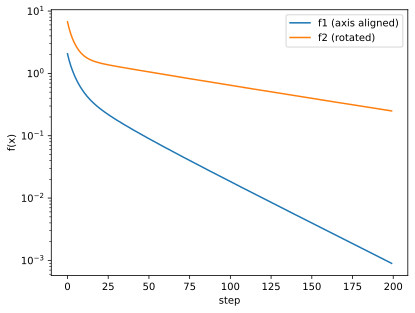

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def adagrad_step(x, grad, s, lr=0.1, eps=1e-8):
    s += grad**2
    x = x - lr * grad / (np.sqrt(s) + eps)
    return x, s

def f1(x):
    return 0.1*x[0]**2 + 2*x[1]**2

def grad_f1(x):
    return np.array([0.2*x[0], 4.0*x[1]])

def f2(x):
    # equivalent to f1(Q x) where Q is 45 degree rotation
    # f2(x) = 0.1*(x1+x2)^2 + 2*(x1-x2)^2
    g1 = 0.2*(x[0]+x[1]) + 4*(x[0]-x[1])
    g2 = 0.2*(x[0]+x[1]) - 4*(x[0]-x[1])
    return np.array([g1, g2])

# init
x0 = np.array([3.0, 1.0])
lr = 0.2
T = 200
eps = 1e-8

# run on f1
x = x0.copy()
s = np.zeros(2)
hist_f1 = []
for t in range(T):
    g = grad_f1(x)
    x, s = adagrad_step(x, g, s, lr, eps)
    hist_f1.append(0.1*x[0]**2 + 2*x[1]**2)

# run on f2
x = x0.copy()
s = np.zeros(2)
hist_f2 = []
for t in range(T):
    g = f2(x)
    x, s = adagrad_step(x, g, s, lr, eps)
    hist_f2.append(0.1*(x[0]+x[1])**2 + 2*(x[0]-x[1])**2)

plt.semilogy(hist_f1, label='f1 (axis aligned)')
plt.semilogy(hist_f2, label='f2 (rotated)')
plt.xlabel('step')
plt.ylabel('f(x)')
plt.legend()
plt.show()

### Bài 3

**Đề bài.** Chứng minh định lý vòng tròn Gerschgorin: với ma trận $\mathbf{M}=(m_{ij})\in\mathbb{C}^{n\times n}$, mọi giá trị riêng $\lambda$ của $\mathbf{M}$ thỏa mãn

$$|\lambda - m_{jj}|\le \sum_{k\ne j} |m_{jk}|$$

cho ít nhất một chỉ số $j$.

**Chứng minh.** Giả sử $\lambda$ là eigenvalue của $\mathbf{M}$ với eigenvector tương ứng $\mathbf{x}=(x_1,\dots,x_n)^\top\ne\mathbf{0}$. Chọn $j$ sao cho $|x_j|=\max_{1\le i\le n}|x_i| >0$. Từ phương trình $\mathbf{M}\mathbf{x}=\lambda\mathbf{x}$, lấy thành phần $j$ ta có

$$(\mathbf{M}\mathbf{x})_j =(\lambda x)_j \implies \sum_{k=1}^n m_{jk} x_k = \lambda x_j.$$

Chuyển số hạng $m_{jj}x_j$ sang vế trái:

$$\sum_{k\ne j} m_{jk} x_k = (\lambda - m_{jj}) x_j.$$

Lấy trị tuyệt đối cả hai vế và áp dụng bất đẳng thức tam giác:

$$|\lambda - m_{jj}|\,|x_j| \;=\; \left|\sum_{k\ne j} m_{jk} x_k\right|
\le \sum_{k\ne j} |m_{jk}|\,|x_k|.$$

Vì $|x_k|\le |x_j|$ theo cách chọn $j$, suy ra

$$|\lambda - m_{jj}|\,|x_j| \le \sum_{k\ne j} |m_{jk}|\,|x_j| = \left(\sum_{k\ne j} |m_{jk}|\right) |x_j|.$$

Chia cả hai vế cho $|x_j|>0$ được

$$|\lambda - m_{jj}| \le \sum_{k\ne j} |m_{jk}|.$$

Đó là điều phải chứng minh. $\square$

### Bài 4

**Đề bài.** Định lý Gerschgorin cho chúng ta biết gì về các trị riêng của ma trận tiền điều hòa theo đường chéo $\text{diag}^{-1/2}(\mathbf{M})\mathbf{M}\text{diag}^{-1/2}(\mathbf{M})$?

**Lời giải.**

#### 1. Xuất phát điểm

Công thức gốc trong tài liệu là:

$$\tilde{\mathbf{Q}} = \text{diag}^{-1/2}(\mathbf{Q}) \cdot \mathbf{Q} \cdot \text{diag}^{-1/2}(\mathbf{Q})$$

Để cho gọn, ta đặt ma trận đường chéo tỉ lệ $\mathbf{S} = \text{diag}^{-1/2}(\mathbf{Q})$. Khi đó:

$$\tilde{\mathbf{Q}} = \mathbf{S} \mathbf{Q} \mathbf{S}$$

#### 2. Định nghĩa các thành phần

Giả sử ma trận $\mathbf{Q}$ có kích thước bất kỳ.

- Ma trận $\mathbf{Q}$: phần tử hàng $i$, cột $j$ là $\mathbf{Q}_{ij}$.
- Ma trận $\mathbf{S}$ là ma trận đường chéo: $\mathbf{S}_{ii} = \frac{1}{\sqrt{\mathbf{Q}_{ii}}}$, $\mathbf{S}_{ij} = 0$ ($i \ne j$).

#### 3. Tính toán cụ thể

Xét ma trận:

$$\mathbf{Q} = \begin{pmatrix} 4 & 1 & 2 \\ 1 & 9 & 3 \\ 2 & 3 & 16 \end{pmatrix}$$

**Bước 1:** $\mathbf{S} = \begin{pmatrix} 1/2 & 0 & 0 \\ 0 & 1/3 & 0 \\ 0 & 0 & 1/4 \end{pmatrix}$

**Bước 2:** $\tilde{\mathbf{Q}} = \begin{pmatrix} 1 & 0.1667 & 0.25 \\ 0.1667 & 1 & 0.25 \\ 0.25 & 0.25 & 1 \end{pmatrix}$

#### Kết luận

Ma trận sau tiền điều hòa có:
- Đường chéo bằng 1
- Các phần tử ngoài đường chéo nhỏ hơn

Do đó theo Định lý Gerschgorin, các trị riêng đều gom quanh 1, tức condition number cải thiện đáng kể.

### Bài 5

**Đề bài.** Thử Adagrad cho một mạng sâu (ví dụ Fashion MNIST). Mô tả những gì nên thử và kỳ vọng.

#### 1. Mục tiêu thí nghiệm

Đánh giá hiệu năng của Adagrad trên bài toán phân loại hình ảnh Fashion MNIST với mạng CNN cơ bản, so sánh với các bộ tối ưu khác (SGD, SGD+momentum, RMSProp, Adam).

**Quan tâm tới:**
- Tốc độ hội tụ (train loss giảm theo epoch)
- Khả năng tổng quát hóa (validation accuracy)
- Hành vi learning-rate hiệu dụng per-parameter (accumulators)
- Tính nhạy với siêu tham số (lr ban đầu, epsilon)

#### 2. Chi tiết kiến trúc

**Dữ liệu:** Fashion MNIST (60k train, 10k test) với chuẩn hóa đơn giản (div 255)

**Kiến trúc CNN:**
```
Conv(32, 3x3) - ReLU - MaxPool(2x2)
Conv(64, 3x3) - ReLU - MaxPool(2x2)
Flatten - FC(128) - ReLU - FC(10)
```

**Siêu tham số:**
- batch_size = 64
- epochs = 20
- lr cho Adagrad: 0.01, 0.05, 0.1 (thử nhiều giá trị)
- epsilon = 1e-8

#### 3. Các thí nghiệm

1. **So sánh bộ tối ưu:** Chạy với Adagrad, SGD, SGD+momentum, RMSProp, Adam. Ghi lại train/val loss và accuracy.

2. **Nhạy cảm với lr:** Thử nhiều learning rate khởi điểm để đánh giá sensitivity.

3. **Đo accumulator:** Plot phân phối $s_{t,i}$ để xem parameter nào bị giảm lr nhiều.

4. **Kiểm tra overfitting:** So sánh learning curves.

5. **Data augmentation:** Thử với và không có augmentation.

#### 4. Kỳ vọng

**Ưu điểm Adagrad:**
- Tự động giảm lr cho tham số có gradient lớn
- Thích hợp với dữ liệu sparse hoặc đặc trưng hiếm

**Nhược điểm:**
- Accumulator cộng dồn vô hạn → learning rate giảm quá mức
- Training có thể dừng cải thiện sớm

**Dự đoán:** Adagrad hội tụ tốt ban đầu nhưng bị chững lại sau vài epoch. RMSProp/Adam thường cho kết quả tốt hơn về lâu dài.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Dữ liệu
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader  = DataLoader(testset, batch_size=256, shuffle=False)

# Mô hình đơn giản
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,128), nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self,x): return self.fc(self.conv(x))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

# Optimizer: Adagrad
optimizer = optim.Adagrad(model.parameters(), lr=0.05, eps=1e-8)
criterion = nn.CrossEntropyLoss()

# Training loop (sơ bộ)
def train_epoch():
    model.train()
    total_loss = 0.0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(train_loader.dataset)

def eval():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    return correct/total

for epoch in range(1,21):
    tr_loss = train_epoch()
    val_acc = eval()
    print(f'Epoch {epoch}: train_loss={tr_loss:.4f}, val_acc={val_acc:.4f}')

### Bài 6

**Đề bài.** Cần sửa đổi Adagrad như thế nào để có được sự phân rã (decay) tốt hơn/ổn hơn trong learning rate?

#### 1. Vấn đề của Adagrad gốc

Adagrad cộng dồn bình phương gradient vô hạn:

$$s_{t,i} = \sum_{\tau=1}^t g_{\tau,i}^2$$

Do $s_{t,i}$ tăng không giảm (non-decreasing) và có thể trở nên rất lớn, thành phần $\sqrt{s_{t,i}}$ giảm rất mạnh theo thời gian, có thể làm bước cập nhật gần bằng 0 trước khi tối ưu tìm tới cực tiểu tốt. Đây là quá trình phân rã quá hung hăng mà bài nói tới.

#### 2. Các sửa đổi phổ biến (chi tiết)

##### a. RMSProp: EMA của bình phương gradient

$$s_t = \beta s_{t-1} + (1-\beta) g_t^2, \quad \beta \in [0.9, 0.99]$$

Thay vì cộng dồn vô hạn, ta sử dụng trung bình mũ (exponential moving average) nên chỉ nhớ lịch sử gần đây. Điều này ngăn $s_t$ tăng lớn vô hạn và giúp learning-rate per-parameter ổn định hơn.

##### b. Adadelta

- Tổng loại bỏ dependency vào learning-rate toàn cục bằng cách sử dụng tỉ số giữa RMS của update và RMS của gradient:

$$\Delta \theta_t = -\frac{\text{RMS}[\Delta\theta]_{t-1}}{\text{RMS}[g]_t} g_t$$

- Adadelta dùng EMA cả cho gradient và cho update, tránh giảm lr quá mức.

##### c. Adam (với bias-correction)

$$m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t$$
$$v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2$$

Sau đó dùng dạng bias-corrected: $\hat{m}_t = \frac{m_t}{1-\beta_1^t}$ và $\hat{v}_t = \frac{v_t}{1-\beta_2^t}$.

Adam dùng EMA cho bình phương gradient như RMSProp và cả moment, dẫn đến ổn định hơn.

##### d. AdaBound

Giới hạn learning-rate per-parameter trong một khoảng thay đổi theo thời gian, tránh quá lớn hoặc quá nhỏ.

##### e. Tăng epsilon hoặc sử dụng smoothing

Dùng $\epsilon$ lớn hơn (ví dụ 1e-6 thay vì 1e-8) làm cho denominator không quá lớn ban đầu.

##### f. Sử dụng restart hoặc reset accumulator

Thỉnh thoảng reset $s_{t,i}$ về 0 hoặc nhân với factor nhỏ để tránh bị đóng băng.

##### g. Learning-rate schedule toàn cục kết hợp

Dùng lr schedule (decay chậm) trên lr ban đầu thay vì phụ thuộc hoàn toàn vào accumulator.

In [1]:
# Ví dụ RMSProp thay cho Adagrad (numpy style đơn giản)
import numpy as np

def grad_f1(x):
    return np.array([0.2*x[0], 4.0*x[1]])

# RMSProp replacement for Adagrad
x = np.array([3.0, 1.0])
s = np.zeros_like(x)
lr = 0.01
rho = 0.9  # decay rate
eps = 1e-8

for t in range(100):
    g = grad_f1(x)  # giả sử grad_f1 đã định nghĩa
    s = rho * s + (1 - rho) * (g ** 2)
    x = x - lr * g / (np.sqrt(s) + eps)

print(f"Final x: {x}")
print(f"Final s (accumulator): {s}")

Final x: [1.94188379 0.08758652]
Final s (accumulator): [0.16641745 0.44378632]


#### 3. Khi nào nên dùng sửa đổi nào?

- **Nếu muốn sửa nhanh:** Chuyển sang **RMSProp** hoặc **Adam** - đây là lựa chọn thực tế và hiệu quả.

- **Nếu bài toán sparse** (ví dụ NLP với features hiếm): Adagrad gốc có thể vẫn tốt; nếu bị giảm quá mạnh, thử tăng epsilon hoặc reset accumulator.

- **Nếu cần kiểm soát chặt chẽ:** Dùng **AdaBound** hoặc clipping upper/lower bound cho lr per-parameter.

#### 4. Kết luận

Để giảm tính hung hăng của việc giảm learning-rate trong Adagrad, cách thực tế và phổ biến nhất là dùng **EMA của bình phương gradient** (RMSProp/Adam), hoặc dùng các biến thể như **Adadelta/AdaBound**. Nếu không muốn đổi thuật toán, thử chỉnh $\epsilon$, reset accumulator, hoặc áp một schedule nhân học cho learning-rate toàn cục.